# SVM实践作业
独宇涵 231880151

邮箱: 231880151@smail.nju.edu.cn

环境: python = 3.12.8
## 实践复现部分
### 数据导入与预处理
这部分需要完成库的导入、数据的加载和预处理

In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 方便后续修改加入Magic Power
%load_ext autoreload
%autoreload 2


In [2]:
# 加载鸢尾花数据集
iris = datasets.load_iris()
X = iris.data # 特征
X = X[:, :2]
y = iris.target # ⽬标标签
# 选择前两类（类别 0: setosa, 类别 1: versicolor）
selected_classes = [0, 1]
mask = np.isin(y, selected_classes)
X_filtered = X[mask]
y_filtered = y[mask]
# 将类别 0 转换成 -1
y_filtered[y_filtered == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3,random_state=1, stratify=y_filtered)

### 划分结果的可视化处理

In [3]:
# 准备绘制的数据点
classified_train_pts = {'+1': [], '-1': []}
for point, label in zip(X_train, y_train):
    if label == 1.0:
        classified_train_pts['+1'].append(point)
    else:
        classified_train_pts['-1'].append(point)

classified_test_pts = {'+1': [], '-1': []}
for point, label in zip(X_test, y_test):
    if label == 1.0:
        classified_test_pts['+1'].append(point)
    else:
        classified_test_pts['-1'].append(point)

In [4]:
# 绘制训练集
def visualize(w,b,title):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    for label, pts in classified_train_pts.items():
        pts = np.array(pts)
        if(label == '+1'):
            ax.scatter(pts[:, 0], pts[:, 1], color='#F78C60', label="versicolor_train")
        else:
            ax.scatter(pts[:, 0], pts[:, 1], color='#8DB1E3', label="setosa_train")

    for label, pts in classified_test_pts.items():
        pts = np.array(pts)
        if(label == '+1'):
            ax.scatter(pts[:, 0], pts[:, 1], color='#FEE3C5', label="versicolor_test")
        else:
            ax.scatter(pts[:, 0], pts[:, 1], color='#C3D4DE', label="setosa_test")

    x1,_ = max(X_train, key = lambda x: x[0])
    x2,_ = min(X_train, key = lambda x: x[0])
    a1, a2 = w
    y1, y2 = (-b - a1*x1)/a2, (-b - a1*x2)/a2
    ax.plot([x1, x2], [y1, y2])

    plt.legend()
    plt.title(title)
    plt.show()

### 基于SGD的线性SVM的实现
SVM的目标函数为：$\min_{W,b} \quad \frac{1}{2} \|W\|^2 + C \sum_i \max(0, 1 - y_i(W \cdot x_i + b))$

在随机梯度下降时，如果$y_{i}(W \cdot x_i + b) \geq 1$时，只更新正则化项的权重$W \leftarrow W - \eta \cdot 2\lambda W$

如果 $y_i(W \cdot x_i + b) < 1$，则同时更新正则化项和损失项$W \leftarrow W - \eta(2\lambda W - y_i \cdot x_i)$，$b \leftarrow b + \eta \cdot y_i$

In [5]:
# 使用SGD实现SVM
class LinearSVM:
    def _init_(self,learning_rate = 0.001, lambda_param = 0.01, epochs = 1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.epochs = epochs
        self.W = None
        self.b = None
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.W = np.zeros(n_features)
        self.b = 0
    
        for epoch in range(self.epochs):
            for i in range(n_samples):
                if y[i] * (np.dot(X[i],self.W) + self.b) < 1:
                    self.W -= self.lr * (2 * self.lambda_param * self.W - np.dot(X[i],y[i]))
                    self.b -= self.lr * y[i]
                else:
                    self.W -= self.lr * (2 * self.lambda_param * self.W)
        
    def predict(self, X):
        return np.sign(np.dot(X, self.W) + self.b)

#### 测试阶段
完成自定义的SVM的算法后可以用iris测试实验结果

SVM 分类器的正确率为: 1.0


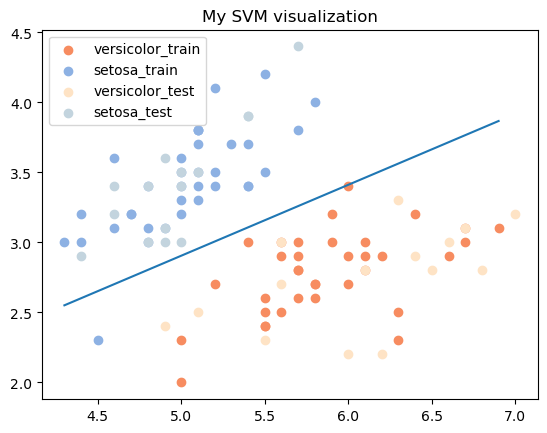

In [6]:
svm = LinearSVM()
svm._init_()
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

accuracy = np.mean(y_pred == y_test)
print("SVM 分类器的正确率为:", accuracy)

visualize(svm.W, svm.b, "My SVM visualization")

### 基于SMO的SVM实现
构建SMO算法的辅助函数

In [7]:
def clip(alpha, L, H):
    ''' 修建alpha的值到L和H之间.
    '''
    if alpha < L:
        return L
    elif alpha > H:
        return H
    else:
        return alpha

def select_j(i, m):
    ''' 在m中随机选择除了i之外剩余的数
    '''
    l = list(range(m))
    seq = l[: i] + l[i+1:]
    return np.random.choice(seq)

def get_w(alphas, dataset, labels):
    ''' 通过已知数据点和拉格朗⽇乘⼦获得分割超平⾯参数w
    '''
    alphas, dataset, labels = np.array(alphas), np.array(dataset), np.array(labels)
    yx = labels.reshape(1,-1).T*np.array([1, 1])*dataset
    w = np.dot(yx.T, alphas)
    return w.tolist()

手动实现简易SMO

In [8]:
def simple_smo(dataset, labels, C, max_iter):
    ''' 简化版SMO算法实现，未使⽤启发式⽅法对alpha对进⾏选择.
    :param dataset: 所有特征数据向量
    :param labels: 所有的数据标签
    :param C: 软间隔常数, 0 <= alpha_i <= C
    :param max_iter: 外层循环最⼤迭代次数
    '''
    dataset = np.array(dataset)
    m, n = dataset.shape
    labels = np.array(labels)
    # 初始化参数
    alphas = np.zeros(m)
    b = 0
    it = 0

    def f(x):
        "SVM分类器函数 y = w^Tx + b"
        # Kernel function vector.
        x = np.matrix(x).T
        data = np.matrix(dataset)
        ks = data*x
        # Predictive value.
        wx = np.matrix(alphas*labels)*ks
        fx = wx + b
        return fx[0, 0]

    while it < max_iter:
        pair_changed = 0
        for i in range(m):
            a_i, x_i, y_i = alphas[i], dataset[i], labels[i]
            fx_i = f(x_i)
            E_i = fx_i - y_i
            j = select_j(i, m)
            a_j, x_j, y_j = alphas[j], dataset[j], labels[j]
            fx_j = f(x_j)
            E_j = fx_j - y_j
            K_ii, K_jj, K_ij = np.dot(x_i, x_i), np.dot(x_j, x_j), np.dot(x_i, x_j)
            eta = K_ii + K_jj - 2*K_ij
            if eta <= 0:
                continue
            # 获取更新的alpha对
            a_i_old, a_j_old = a_i, a_j
            a_j_new = a_j_old + y_j*(E_i - E_j)/eta
            # 对alpha进⾏修剪
            if y_i != y_j:
                L = max(0, a_j_old - a_i_old)
                H = min(C, C + a_j_old - a_i_old)
            else:
                L = max(0, a_i_old + a_j_old - C)
                H = min(C, a_j_old + a_i_old)
            a_j_new = clip(a_j_new, L, H)
            a_i_new = a_i_old + y_i*y_j*(a_j_old - a_j_new)
            if abs(a_j_new - a_j_old) < 0.00001:
                continue
            alphas[i], alphas[j] = a_i_new, a_j_new
            # 更新阈值b
            b_i = -E_i - y_i*K_ii*(a_i_new - a_i_old) - y_j*K_ij*(a_j_new - a_j_old) + b
            b_j = -E_j - y_i*K_ij*(a_i_new - a_i_old) - y_j*K_jj*(a_j_new - a_j_old) + b
            if 0 < a_i_new < C:
                b = b_i
            elif 0 < a_j_new < C:
                b = b_j
            else:
                b = (b_i + b_j)/2
            pair_changed += 1
        if pair_changed == 0:
            it += 1
        else:
            it = 0
    return alphas, b

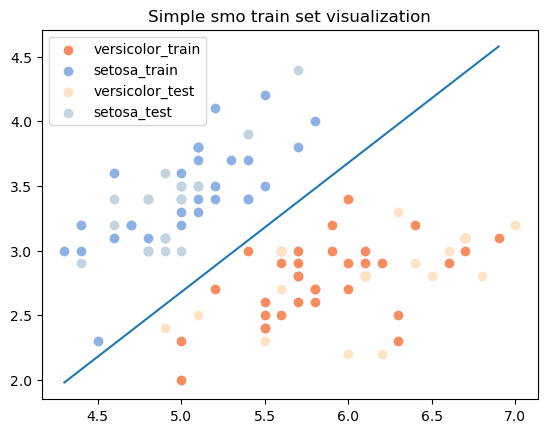

In [13]:
# 使⽤简化版SMO算法优化SVM
alphas, b = simple_smo(X_train, y_train, 0.6, 40)
w = get_w(alphas, X_train, y_train)
visualize(w, b, "Simple smo train set visualization")

### 调用Sklearn内部的SVM方法

SVM 分类器的准确率: 1.0


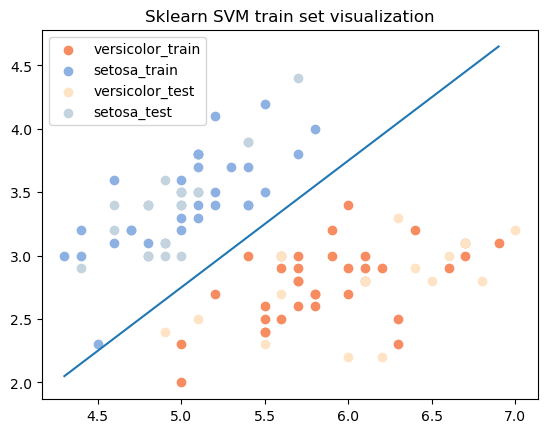

In [9]:
from sklearn.svm import SVC
svm_sklearn = SVC(kernel='linear')
svm_sklearn.fit(X_train, y_train)
y_pred_sklearn = svm_sklearn.predict(X_test)
# 计算准确率
accuracy = np.mean(y_pred_sklearn == y_test)
print("SVM 分类器的准确率:", accuracy)
# 绘制训练集和测试集数据点
visualize(svm_sklearn.coef_[0], svm_sklearn.intercept_, "Sklearn SVM train set visualization")

## 思考题一：实现三分类iris数据集的分类与可视化

In [10]:
data = iris.data
label = iris.target
class_names = iris.target_names
print("类别名称：", class_names)
# print(label) label中一共有0，1，2三个类别

类别名称： ['setosa' 'versicolor' 'virginica']


首先只保留前两个标签的情况下（更方便进行可视化展示）进行分类，并且计算正确率

In [11]:
data_2 = data[:, :2]
print("Shape of data:", data_2.shape)
print("Shape of label:", label.shape)
data_train_2, data_test_2, label_train_2, label_test_2 = train_test_split(data_2, label, test_size=0.3,random_state=1, stratify=label)

Shape of data: (150, 2)
Shape of label: (150,)


采用sklearn的SVC方法来创建多分类SVM，Kernel采用线性函数的形式

In [12]:
#Create the SVM model
from sklearn.svm import SVC
multiple_classifier_2 = SVC(kernel = 'linear', random_state = 0)
#Fit the model for the data
multiple_classifier_2.fit(data_train_2, label_train_2)
#Make the prediction
label_pred_2 = multiple_classifier_2.predict(data_test_2)

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_2 = confusion_matrix(label_test_2, label_pred_2)

from sklearn.model_selection import cross_val_score
accuracies_2 = cross_val_score(estimator = multiple_classifier_2, X = data_train_2, y = label_train_2, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies_2.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_2.std()*100))

Accuracy: 87.82 %
Standard Deviation: 10.87 %


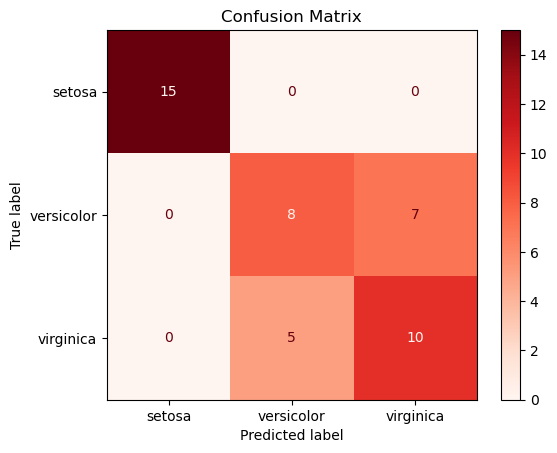

In [14]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=iris.target_names)
disp.plot(cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.show()

从混淆矩阵中看出如果只采用前两个标签对于versicolor和virginca的区分效果很差（测试保留其他两个特征测试结果更差），下面尝试绘制分类结果

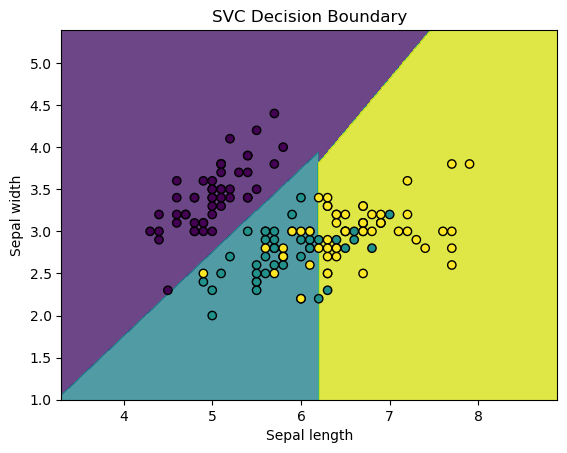

In [15]:
h = .01  # 网格点的步长
x_min, x_max = data_2[:, 0].min() - 1, data_2[:, 0].max() + 1
y_min, y_max = data_2[:, 1].min() - 1, data_2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# 预测网格点的类别
Z = multiple_classifier_2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 绘制决策边界
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(data_2[:, 0], data_2[:, 1], c=label, edgecolors='k', marker='o')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('SVC Decision Boundary')
plt.show()

下面尝试保留三个特征提升正确率（保留四个特征相较于保留前三个特征对于划分正确率的提升不大，故只保留前三个特征，并且采用三维散点图进行可视化操作

In [16]:
data_3 = iris.data
data_3 = data_3[:, :3]
print("Shape of data:", data_3.shape)
print("Shape of label:", label.shape)
data_train_3, data_test_3, label_train_3, label_test_3 = train_test_split(data_3, label, test_size=0.3,random_state=1, stratify=label)

Shape of data: (150, 3)
Shape of label: (150,)


In [17]:
#Create the SVM model
multiple_classifier_3 = SVC(kernel = 'linear', random_state = 0, C = 1)
#Fit the model for the data
multiple_classifier_3.fit(data_train_3, label_train_3)
#Make the prediction
label_pred_3 = multiple_classifier_3.predict(data_test_3)

In [18]:
cm_3 = confusion_matrix(label_test_3, label_pred_3)

accuracies_3 = cross_val_score(estimator = multiple_classifier_3, X = data_train_3, y = label_train_3, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies_3.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_3.std()*100))

Accuracy: 95.27 %
Standard Deviation: 4.74 %


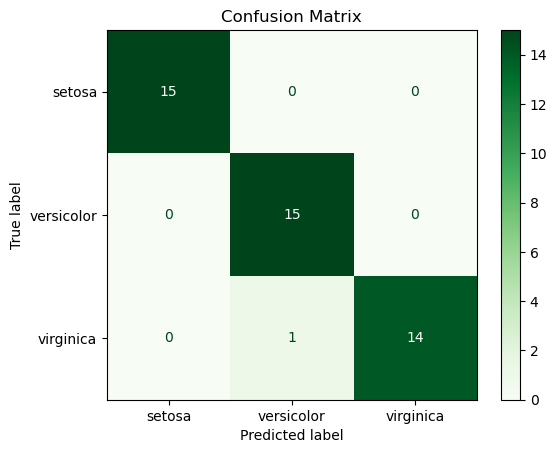

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=iris.target_names)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.show()

/var/folders/cn/cmszjn2x34l9zdtb07mszfl00000gn/T/ipykernel_33267/2503729106.py:8: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(data_test_3[:, 0], data_test_3[:, 1], data_test_3[:, 2], c=label_pred_3, cmap=plt.cm.Set1, edgecolor='k', s=100, marker='x', label='Test Data')


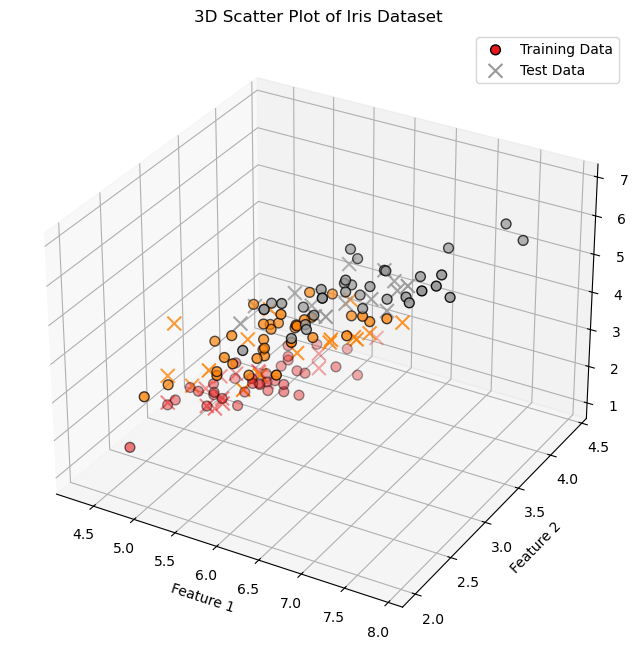

In [21]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制训练集数据
ax.scatter(data_train_3[:, 0], data_train_3[:, 1], data_train_3[:, 2], c=label_train_3, cmap=plt.cm.Set1, edgecolor='k', s=50, label='Training Data')
# 绘制测试集数据
ax.scatter(data_test_3[:, 0], data_test_3[:, 1], data_test_3[:, 2], c=label_pred_3, cmap=plt.cm.Set1, edgecolor='k', s=100, marker='x', label='Test Data')

# 设置标签
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Scatter Plot of Iris Dataset')
ax.legend()

plt.show()

除了上述方法外，也可以尝试用PCA将数据从三维降到二维方便后续进行可视化处理，且在实际操作后这种方法下正确率与降维前相同，更易于绘制分离图像

/var/folders/cn/cmszjn2x34l9zdtb07mszfl00000gn/T/ipykernel_33267/3700948082.py:24: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=label_test_3, edgecolors='k', marker='x', label='Test Data')


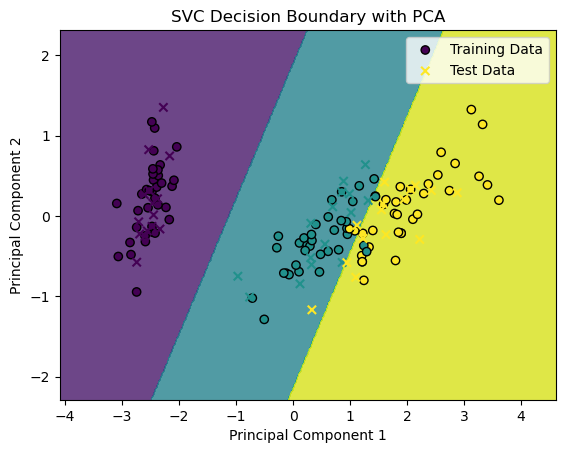

In [22]:
from sklearn.decomposition import PCA
# 使用 PCA 将数据降维到二维
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(data_train_3)
X_test_pca = pca.transform(data_test_3)

# 训练 SVC 模型
clf = SVC(kernel='linear', random_state=1)
clf.fit(X_train_pca, label_train_3)

# 创建网格点
h = .02  # 网格点的步长
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# 预测网格点的类别
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 绘制决策边界
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=label_train_3, edgecolors='k', marker='o', label='Training Data')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=label_test_3, edgecolors='k', marker='x', label='Test Data')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVC Decision Boundary with PCA')
plt.legend()
plt.show()

In [23]:
accuracies_pca = cross_val_score(estimator = clf, X = X_train_pca, y = label_train_3, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies_pca.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_pca.std()*100))

Accuracy: 95.27 %
Standard Deviation: 4.74 %


## 思考题二：切换其他线性不可分的数据集并且测试多种Kernel函数
这里使用sklearn自带的make_moons来制作线性不可分的二分类数据集

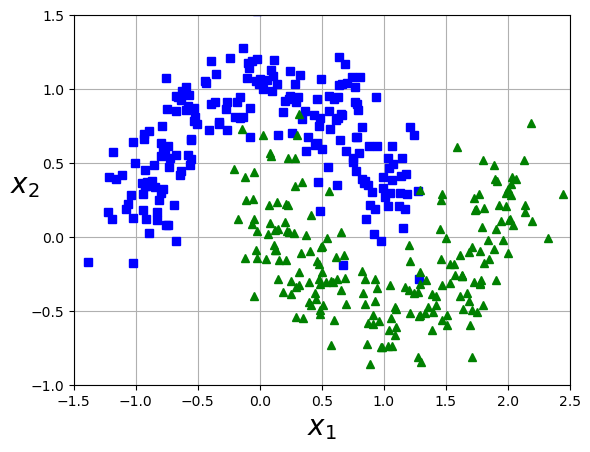

In [25]:
from sklearn.datasets import make_moons
a, b = make_moons(n_samples=400, noise=0.18, random_state=40)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(a, b, [-1.5, 2.5, -1, 1.5])
plt.show()

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC, NuSVC
import time  # 新增时间模块
#划分数据集
X_train, X_test, y_train, y_test = train_test_split(a, b, test_size=0.2, random_state=42)
#数据标准化处理
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# 初始化不同SVM模型
svm_linear = LinearSVC(max_iter=10000, random_state=42)
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_poly = SVC(kernel='poly', degree=3, random_state=42)
svm_nu = NuSVC(random_state=42,nu=0.1)

In [33]:
# 训练模型
start = time.time()
svm_linear.fit(X_train_scaled, y_train)
linear_time = time.time() - start

start = time.time()
svm_rbf.fit(X_train_scaled, y_train)
rbf_time = time.time() - start

start = time.time()
svm_poly.fit(X_train_scaled, y_train)
poly_time = time.time() - start

start = time.time()
svm_nu.fit(X_train_scaled, y_train)
nu_time = time.time() - start

In [34]:
models = [svm_linear, svm_rbf, svm_poly, svm_nu]
model_names = ['LinearSVC', 'RBF SVC', 'Poly SVC', 'NuSVC']
training_times = [linear_time, rbf_time, poly_time, nu_time]

In [35]:
from sklearn.metrics import accuracy_score
for model, name, t in zip(models, model_names, training_times):
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name.ljust(15)} 准确率: {accuracy:.4f}  \t训练时间: {t:.4f}秒")

LinearSVC       准确率: 0.9250  	训练时间: 0.0038秒
RBF SVC         准确率: 0.9625  	训练时间: 0.0014秒
Poly SVC        准确率: 0.9375  	训练时间: 0.0013秒
NuSVC           准确率: 0.9750  	训练时间: 0.0013秒


从上述训练结果中可以看出分类效果最好的是NuSVC，NuSVC相较于传统的传统的SVC引入了nu参数来控制支持向量占据所有向量的比例，其默认的核函数为高斯核函数，适用于非线性可分的分类问题。

此外，可以看出在解决Moons数据集的问题上，rbf核函数的表现效果要比线性核与poly核效果更好，poly在设置高阶多项式后容易导致过拟合反而使得表现更差

In [30]:
def plot_decision_boundary(clf, scaler, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    if scaler is not None:
        X_new = scaler.transform(X_new)
    y_pred = clf.predict(X_new).reshape(x1.shape)
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap='Paired')
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

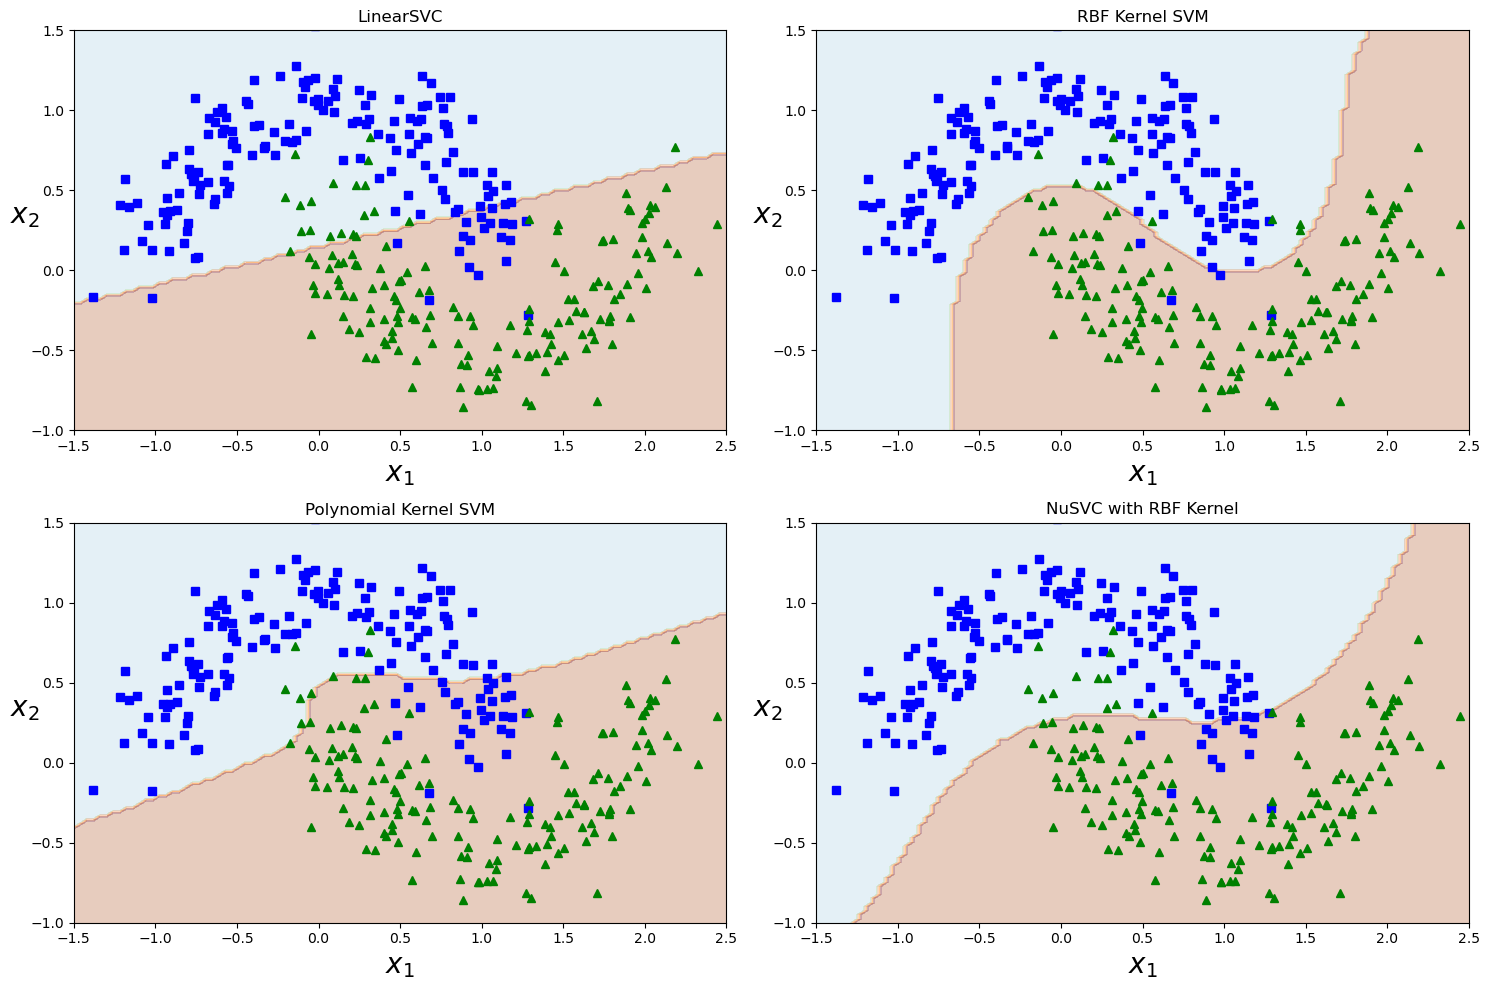

In [31]:
# 绘制决策边界
plt.figure(figsize=(15, 10))
plt.subplot(221)
plot_decision_boundary(svm_linear, scaler, X_train, y_train, [-1.5, 2.5, -1, 1.5])
plt.title("LinearSVC")

plt.subplot(222)
plot_decision_boundary(svm_rbf, scaler, X_train, y_train, [-1.5, 2.5, -1, 1.5])
plt.title("RBF Kernel SVM")

plt.subplot(223)
plot_decision_boundary(svm_poly, scaler, X_train, y_train, [-1.5, 2.5, -1, 1.5])
plt.title("Polynomial Kernel SVM")

plt.subplot(224)
plot_decision_boundary(svm_nu, scaler, X_train, y_train, [-1.5, 2.5, -1, 1.5])
plt.title("NuSVC with RBF Kernel")

plt.tight_layout()
plt.show()

## 思考题三:SVM的底层实现
sklearn中的SVM库依赖于LIBSVM和LIBLINEAR这两个库的实现（林智仁教授团队开发的产品），其中LIBSVM适合于非线性SVM的拟合，支持多种核函数（高斯核、多项式核等），内部采用SMO算法，在处理小规模非线性数据时效率非常高且具有高准确率。而LIBLINEAR库则采用了梯度下降算法，在处理大规模高维数据时效率非常高。

sklearn的SVM算法并非是最优的算法，他的LIBSVM无法处理超大规模数据，而LIBLINEAR无法使用GPU加速，这种算法属于是准确率与效率平衡下的结果。